# TP2 Mean Shift

Read, understand, and complete and run the following notebook. You must return the completed notebook, including your answers and illustrations (you may need to add cells to write your code or comments). 

Return your work by e-mail using a single file (ipynb or zip) with the format 'introvis18_tp2_yourname.ipynb'


## 0. Imports

In [1]:
import numpy as np 
# this is the key library for manipulating arrays. Use the online ressources! http://www.numpy.org/

import matplotlib.pyplot as plt 
# used to read images, display and plot http://matplotlib.org/api/pyplot_api.html . 
#You can also check this simple intro to using ipython notebook with images https://matplotlib.org/users/image_tutorial.html

#%matplotlib inline 
# to display directly in the notebook

import scipy.ndimage as ndimage
# one of several python libraries for image procession

plt.rcParams['image.cmap'] = 'gray' 
# by default, the grayscale images are displayed with the jet colormap: use grayscale instead

from skimage.color import rgb2lab,lab2rgb
# for colorspace conversions

import random as rd

from drawnow import drawnow

## 1. Mean shift

In this section, we will implement Mean Shift and test is on simple synthetic data (i.e. points you will sample from a probability distribution with known density - see below).

1: Generate a random vector of 100 2D points 'data1' with 50 points sampled from a Gaussian distribution of variance 1 centered in (0,0) and 50 points sampled from a Gaussian distribution of variance 1 centered in (2,1). Plot your points using the 'plt.scatter' function. This 'data' vector will be the synthetic data you will try to cluster, and for which the algorithm should manage to separate the point coming from each of the two Gaussians. Repeat to create a vector 'data2' with the center of the second Gaussian in (3,3). Which will be the easiest data vector to cluster? Test both in the following experiments.

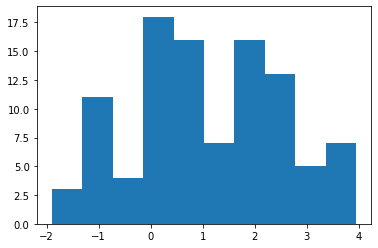

(array([11., 10., 16., 12., 10.,  7., 16., 12.,  4.,  2.]),
 array([-1.69591357, -0.98149763, -0.2670817 ,  0.44733423,  1.16175017,
         1.8761661 ,  2.59058204,  3.30499797,  4.0194139 ,  4.73382984,
         5.44824577]),
 <a list of 10 Patch objects>)

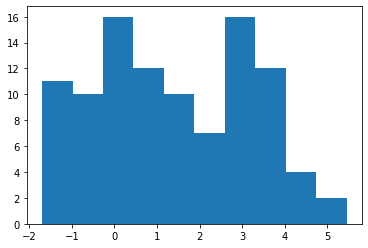

In [2]:
def normal(x, mu, sigma):
    return ( 2.*np.pi*sigma**2. )**-.5 * np.exp( -.5 * (x-mu)**2. / sigma**2. )


def compute_vector(mean1, var1, mean2, var2, nb_points):
    data1 = np.random.normal(mean1, var1, nb_points//2) 
    data2 = np.random.normal(mean2, var2, nb_points//2) 
    data = np.concatenate((data1, data2))
    return data



data = compute_vector(0, 1, 2, 1, 100)
data2 = compute_vector(0, 1, 3, 1, 100)


plt.hist(data)
plt.show()
plt.hist(data2)

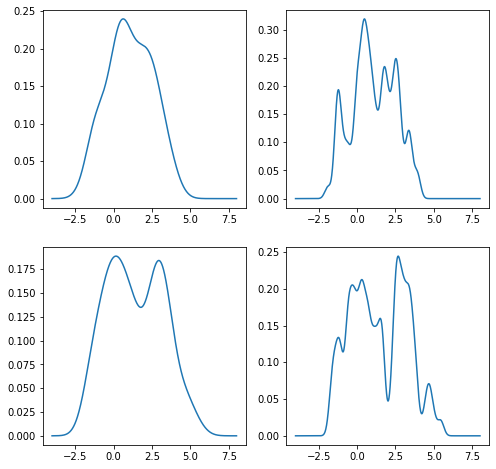

In [3]:
def kernel_density_estimator(x, data, h):
    sum = 0
    n = len(data)
    for i in range(n):
        sum += normal((x - data[i])/h, 0, 1)
    return sum/(len(data) * h)

def density(data, h):
    x_abs= np.linspace(-4, 8, 1000)
    y_ord = []
    for elem in x_abs:
        y_ord.append(kernel_density_estimator(elem, data, h))
    return x_abs, y_ord

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (8, 8))

x_abs1, y_ord1 = density(data, 0.6)
ax1.plot(x_abs1, y_ord1)
x_abs2, y_ord2 = density(data, 0.2)
ax2.plot(x_abs2, y_ord2)
x_abs3, y_ord3 = density(data2, 0.6)
ax3.plot(x_abs3, y_ord3)
x_abs4, y_ord4 = density(data2, 0.2)
ax4.plot(x_abs4, y_ord4)


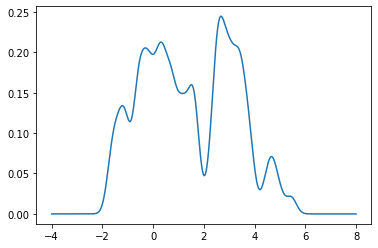

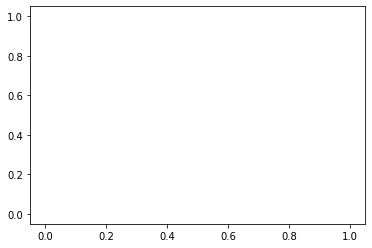

In [6]:
def normal_derivative(x, mu, sigma):
    return ( (-(x - mu) / sigma**2)*(2.*np.pi*sigma**2. )**-.5 * np.exp( -.5 * (x-mu)**2. / sigma**2. ))

def kernel_density_estimator_derivative(x, data, h):
    sum = 0
    n = len(data)
    for i in range(n):
        sum += normal_derivative((x - data[i])/h, 0, 1)
    return sum/(len(data) * h**2)

def mean_shift_value(x, data, h):
    n = len(data)
    sum1 = 0
    sum2 = 0
    for i in range(n):
        sum1 += data[i]*kernel_density_estimator_derivative(x - data[i], data, h)
        sum2 += kernel_density_estimator_derivative(x - data[i], data, h)
    return sum1/(sum2 + 1*10**-16) - x


def makeFig(xList, yList):
    fig = plt.scatter(xList,yList) 
    
plt.ion()
fig=plt.figure()


def mean_shift_algo(data, h):
    data_copy = data.copy()
    converge = []
    for elem in data_copy:
        xList = []
        yList = []
        c=0
        while abs(mean_shift_value(elem, data, h)) > 0.4 and c<100:
            elem = elem + mean_shift_value(elem, data, h)
            y = kernel_density_estimator(elem, data, h)
            #xList.append(elem)
            #yList.append(y)
            #makeFig(xList, yList)
            #plt.pause(0.001)
            c+=1
 
        if abs(mean_shift_value(elem, data, h)) <= 0.3:
            converge.append(elem)

    return converge
            
converge = mean_shift_algo(data2, 0.2)
y_converge = []
for elem in converge:
    y_converge.append(kernel_density_estimator(elem, data2, 0.2))
    
plt.plot(x_abs4, y_ord4)

plt.show()

plt.scatter(converge, y_converge)

    

2: We will segment images using a different distance parameter for space and color. For this reason, we will use a d dimensionnal vector 'sigma' as a parameter for all our mean-shift functions. It defines a scale for each dimension. What would be a meaningful parameter sigma for each of the synthetic data sets (data1 and data2)?

3: Implement the function MS_step which takes as input a vector of all the data point 'data', a starting point 'x' and the standard deviations 'sigma' and returns the updated position of the point 'x' after one step of the mean-shift algorithm. Test it on your synthetic data and visualize the result.

Be cautious: the formula in the lecture are mostly in the isotropic case. In the anisotropic case, you can either redo the derivation, or simply scale the components to come back to the isotropic case.

In [5]:
def MS_step(data,x,sigma):
    # complete

SyntaxError: unexpected EOF while parsing (<ipython-input-5-ceb0227d3332>, line 2)

4: Implement the function MS_point which iterates MS_step until convergence (e.g. the estimate changes by less than 0.01). Test it on your synthetic data and visualize the results.

In [ ]:
def MS_point(data,x,sigma):
    #complete

5: Implement the MS function, which implements the full mean shift algorithm by iterating MS_point on all the points, and merging modes which distance normalized by sigma -- sqrt[sum[((x-y)/sigma)**2) ]] -- is smaller than 0.5 . It must return a list of the modes and a label (corresponding to a mode) for each point.

In [ ]:
def MS(data,sigma):
    labels=np.zeros([data.shape[0],1])
    modes=np.zeros([0,data.shape[1]])
    # complete
    return labels,modes

## 2. Segmentation

1: Download [this small image](http://imagine.enpc.fr/~aubrym/lectures/introvis17/legumes_small.jpg), load it and convert it to the Lab colorspace. Why is it necessary to change colorspace? What are the range of the colorvalues in Lab? 

In [ ]:
# complete

2: In Mean Shift segmentation, all pixels in the image will be treated as data points including both their color and position in the image. Convert the (N,M,3) image into an (NM,5) array incuding color and position information for each point. What would be a meaningful value for sigma?

Tip: use the np.meshgrid function

3: Use the MS function from the previous section to compute a meaningful segmentation of the image. Visualize the results as an image by replacing the color values of the pixels associated to each mode by the color of the mode.